In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score

from importlib import reload
import matplotlib.pyplot as plt

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers
import model_paths

from tensorboardX import SummaryWriter
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [160]:
def get_auroc(model_list, model_params, stats, device):
    auroc = []
    success_rate = []
    conf_list = []
    for i, model in enumerate(model_list):
        with torch.no_grad():
            conf = []
            for data, _ in model_params.test_loader:
                data = data.to(device)

                output = model(data).max(1)[0].exp()

                conf.append(output.cpu())

        conf = torch.cat(conf, 0)

        y_true = torch.cat([torch.ones_like(conf.cpu()), 
                            torch.zeros_like(stats[i])]).cpu().numpy()
        y_scores = torch.cat([conf.cpu(), 
                              stats[i]]).cpu().numpy()
        success_rate.append((stats[i] > conf.mean()).float().mean().item())
        auroc.append(roc_auc_score(y_true, y_scores))
        conf_list.append(conf)
    return auroc, success_rate, conf_list

In [156]:
steps = 200
alpha = 1.
restarts = 10
batches = 10
batch_size = 100

In [21]:
dataset = 'MNIST'
device = torch.device('cuda:7')

model_params = params.params_dict[dataset]()
model_path = model_paths.model_dict[dataset]() 
model_list = [torch.load(file).to(device) for file in model_path.files]
gmm = model_list[-1].mm

shape = enumerate(model_params.cali_loader).__next__()[1][0][0].shape

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [22]:
shape = enumerate(model_params.cali_loader).__next__()[1][0][0].shape

In [157]:
stats, bounds = ev.aggregate_adv_stats(model_list, gmm, device, shape, classes=model_params.classes, 
                                       batches=batches, batch_size=batch_size, steps=steps, 
                                       restarts=restarts, alpha=alpha, lam=lam)
auroc, success_rate, conf = get_auroc(model_list, model_params, stats, device)

In [26]:
pca = models.MyPCA(gmm.metric.comp_vecs.t(), gmm.metric.singular_values, shape)

In [158]:
auroc, success_rate = get_auroc(model_list, model_params, stats, device)

tensor([0.9855, 0.9647, 0.1023, 0.1000])
[0.9549999833106995, 0.9229999780654907, 0.9990000128746033, 0.0]
[0.2884072, 0.42128495000000005, 0.002650850000000002, 1.0]


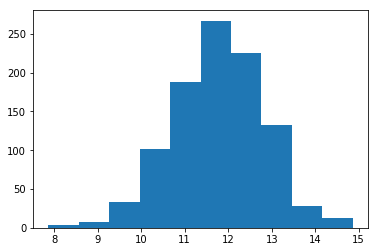

In [159]:
print(stats.mean(1))
print(success_rate)
print(auroc)
plt.hist(bounds)
plt.show()

In [138]:
def gen_pca_noise(model, device, seed, pca, epsilon, restarts=1, perturb=False, steps=40, alpha=0.01):
    batch_size = seed.shape[0]
    if restarts>1:
        data = seed.clone()
        losses = -100000.*torch.ones(batch_size, device=device)
        current_data, current_losses = gen_pca_noise(model, device, seed, pca, epsilon,
                                                     restarts=1, perturb=True, steps=steps, alpha=alpha)
        index = losses < current_losses
        data[index] = current_data[index]
        return data, losses
        
    else:
        with torch.no_grad():
            alpha = alpha * torch.ones(batch_size,1, device=device)

            orig_data_pca = pca.trans(seed)
            prev_data_pca = pca.trans(seed).to(device)
            data_pca = pca.trans(seed).requires_grad_()

            if perturb:
                perturbation = epsilon[:,None]*(torch.rand_like(prev_data_pca) - .5)
                prev_data_pca += perturbation
                data_pca += perturbation

            prev_losses = -100000.*torch.ones(batch_size, device=device)
            prev_grad = torch.zeros_like(data_pca, device=device)

        for _ in range(steps):
            with torch.enable_grad():
                y = model(pca.inv_trans(data_pca))
                losses = y.max(1)[0]
                grad = torch.autograd.grad (losses.sum(), data_pca)[0]

            with torch.no_grad():
                regret_index = losses < prev_losses
                alpha[regret_index] /= 2.
                data_pca[regret_index] = prev_data_pca[regret_index]
                grad[regret_index] = prev_grad[regret_index]

                prev_losses=losses
                prev_data_pca = data_pca
                prev_grad = grad

                data_pca += alpha*grad
                
                delta = data_pca - orig_data_pca
                N = delta.norm(dim=-1)

                index = N>epsilon

                delta[index] *= (epsilon[index] / N[index])[:, None]


                data_pca = orig_data_pca + delta

                data = pca.inv_trans(data_pca)
                data = torch.clamp(data, 0, 1)
                data_pca = pca.trans(data).requires_grad_()
                
        for _ in range(10):
            with torch.no_grad():
                    delta = data_pca - orig_data_pca
                    N = delta.norm(dim=-1)

                    index = N>epsilon

                    delta[index] *= (epsilon[index] / N[index])[:, None]


                    data_pca = orig_data_pca + delta

                    data = pca.inv_trans(data_pca)
                    data = torch.clamp(data, 0, 1)
                    data_pca = pca.trans(data)
        y = model(data)
        losses = y.max(1)[0]
        return data, losses    

In [139]:
class ModelODIN(nn.Module):
    def __init__(self, model, epsilon, device=torch.device('cpu')):
        super().__init__()
        self.epsilon = epsilon
        self.device = device
        self.model = model.to(device)
        
    def forward(self, x):
        x = self.FGSM(x)
        x = self.model(x)
        return x
    
    def FGSM(self, x):
        with torch.enable_grad():
            
            x = x.requires_grad_()
            y = self.model(x)
            losses = y.max(1)[0]
            loss = losses.sum()
            #loss.backward()
            grad = torch.autograd.grad (losses.sum(), x)[0]
  
        x = x + self.epsilon * grad
        x = torch.clamp(x, 0, 1).requires_grad_()
        return x

In [140]:
myodin = ModelODIN(odin_model.model, odin_model.epsilon, device)

In [141]:
myodin(seed);

In [142]:
epsilon= torch.ones(10, device=device)

In [144]:
adv_noise, _ = gen_pca_noise(myodin, device, seed, pca, epsilon)

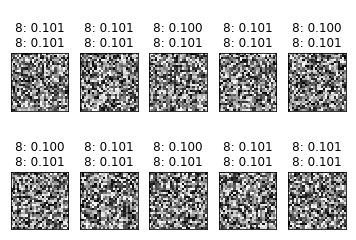

In [145]:
y1 = myodin(seed)
y2 = myodin(adv_noise)

plotting.plot_samples([y1, y2], adv_noise)

In [146]:
model_list[-2] = myodin

In [149]:
stats

tensor([[0.9999, 0.9999, 0.9999,  ..., 0.9998, 0.9999, 1.0000],
        [0.9998, 0.9999, 0.9998,  ..., 0.9999, 0.9995, 0.9749],
        [0.1011, 0.1012, 0.1011,  ..., 0.1012, 0.1012, 0.1015],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]])

In [161]:
auroc, success_rate, conf = get_auroc(model_list, model_params, stats, device)

In [163]:
conf[0].mean()

tensor(0.9917)

In [164]:
success_rate

[0.9549999833106995, 0.9229999780654907, 0.9990000128746033, 0.0]